In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from scipy.integrate import trapz, cumtrapz

from astropy import units as u 
from astropy.table import Table

from snewpy.neutrino import ThreeFlavor, MassHierarchy, ThreeFlavorMixingParameters, MixingParameters
from snewpy.models import Nakazato_2013
from snewpy.models.ccsn import Fornax_2022
from snewpy.models.ccsn import Bollig_2016
from snewpy.models.ccsn import Sukhbold_2015
from snewpy.flavor_transformation import AdiabaticMSW, NonAdiabaticMSWH

C:\Users\sanya\AppData\Local\Temp\ipykernel_31464\3153270610.py:11: FutureWarning: snewpy.models.Nakazato_2013 is moved to snewpy.models.ccsn.Nakazato_2013
  from snewpy.models import Nakazato_2013


In [2]:
def get_model_flux(model, t, E, xform=None):
    #- Spectrum vs t, E
    if xform is None:
        ispec = model.get_initial_spectra(t, E)[ThreeFlavor.NU_E_BAR]
    else:
        ispec = model.get_transformed_spectra(t, E, xform)[ThreeFlavor.NU_E_BAR]
    
    #- Spectrum with maximum scaled to 1.
    #  Use it to compute <E> vs time.
    inorm = ispec / np.max(ispec, axis=1)[:, np.newaxis]
    _E_out = np.outer(np.ones(len(t)), E)
    Eavg = np.average(_E_out, axis=1, weights=inorm)

    #- Spectrum normalized to 1.
    #  Use it to compute the quantiles of the distribution.
    iquant = cumtrapz(ispec, axis=1)
    iquant /= iquant[:,-1][:, np.newaxis]
    
    i = np.argmin(np.abs(iquant - 0.16), axis=1)
    E16 = np.take_along_axis(_E_out, i[:, np.newaxis], axis=1).flatten()
    
    j = np.argmin(np.abs(iquant - 0.84), axis=1)
    E84 = np.take_along_axis(_E_out, j[:, np.newaxis], axis=1).flatten()

    return ispec, inorm, Eavg, E16, E84

In [3]:
model = Sukhbold_2015(progenitor_mass=27.0*u.solMass, eos='LS220')

In [4]:
t = np.arange(0, 500, 1) * u.ms
E = np.arange(0, 100, 0.25) * u.MeV

# ispec = model.get_initial_spectra(t, E)[Flavor.NU_E_BAR]
# inorm = ispec / np.max(ispec, axis=1)[:, np.newaxis]
# _E_out = np.outer(np.ones(len(t)), E)
# Eavg = np.average(_E_out, axis=1, weights=inorm)

# #- Spectrum normalized to 1.
# #  Use it to compute the quantiles of the distribution.
# iquant = cumtrapz(ispec, axis=1)
# iquant /= iquant[:,-1][:, np.newaxis]

# i = np.argmin(np.abs(iquant - 0.16), axis=1)
# E16 = np.take_along_axis(_E_out, i[:, np.newaxis], axis=1).flatten()

# j = np.argmin(np.abs(iquant - 0.84), axis=1)
# E84 = np.take_along_axis(_E_out, j[:, np.newaxis], axis=1).flatten()

(0.0, 25.0)

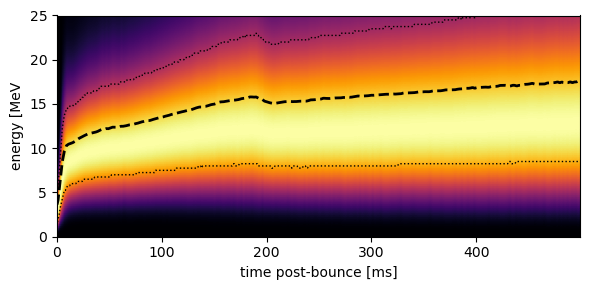

In [6]:
ispec, inorm, Eavg, E16, E84 = get_model_flux(model, t, E)

fig, ax = plt.subplots(1,1, figsize=(6,3), tight_layout=True)
extents = [
    t[0].to_value('ms'),
    t[-1].to_value('ms'),
    E[0].to_value('MeV'),
    E[-1].to_value('MeV')
]
ax.imshow(inorm.T, origin='lower', extent=extents, aspect='auto', cmap='inferno')
ax.plot(t, E16, color='k', lw=1, ls=':')
ax.plot(t, Eavg, color='k', lw=2, ls='--')
ax.plot(t, E84, color='k', lw=1, ls=':')
ax.set(xlabel='time post-bounce [ms]',
       ylabel='energy [MeV')
ax.set_ylim(0,25)

[Text(0.5, 0, 'time [ms]'), Text(0, 0.5, 'energy [MeV'), (0.0, 25.0)]

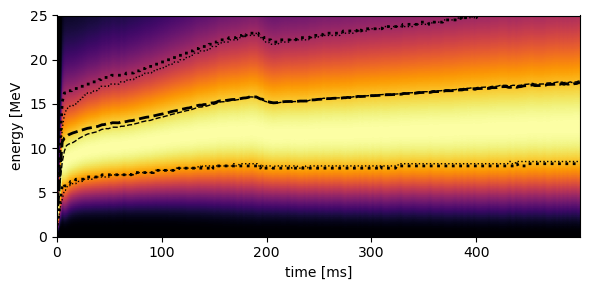

In [13]:
mix_params_nmo = ThreeFlavorMixingParameters(**MixingParameters(mass_order=MassHierarchy.NORMAL))
ispec_nmo, inorm_nmo, Eavg_nmo, E16_nmo, E84_nmo = get_model_flux(model, t, E, 
                                            AdiabaticMSW(mix_params_nmo))

fig, ax = plt.subplots(1,1, figsize=(6,3), tight_layout=True)
extents = [
    t[0].to_value('ms'),
    t[-1].to_value('ms'),
    E[0].to_value('MeV'),
    E[-1].to_value('MeV')
]
ax.imshow(inorm_nmo.T, origin='lower', extent=extents, aspect='auto', cmap='inferno')

ax.plot(t, E16, color='k', lw=1, ls=':')
ax.plot(t, Eavg, color='k', lw=1, ls='--')
ax.plot(t, E84, color='k', lw=1, ls=':')

ax.plot(t, E16_nmo, color='k', lw=2, ls=':')
ax.plot(t, Eavg_nmo, color='k', lw=2, ls='--')
ax.plot(t, E84_nmo, color='k', lw=2, ls=':')
ax.set(xlabel='time [ms]',
       ylabel='energy [MeV',
      ylim=(0,25))

[Text(0.5, 0, 'time [ms]'), Text(0, 0.5, 'energy [MeV'), (0.0, 25.0)]

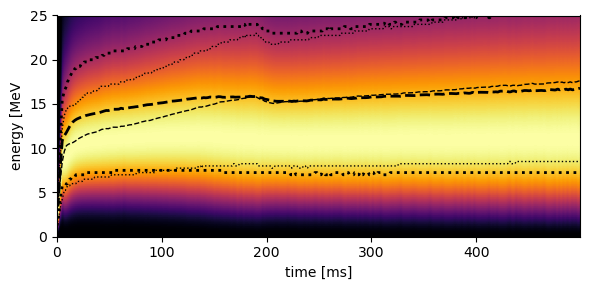

In [15]:
mix_params_imo = ThreeFlavorMixingParameters(**MixingParameters(mass_order=MassHierarchy.INVERTED))
ispec_imo, inorm_imo, Eavg_imo, E16_imo, E84_imo = get_model_flux(model, t, E, AdiabaticMSW(mix_params_imo))

fig, ax = plt.subplots(1,1, figsize=(6,3), tight_layout=True)
extents = [
    t[0].to_value('ms'),
    t[-1].to_value('ms'),
    E[0].to_value('MeV'),
    E[-1].to_value('MeV')
]
ax.imshow(inorm_imo.T, origin='lower', extent=extents, aspect='auto', cmap='inferno')

ax.plot(t, E16, color='k', lw=1, ls=':')
ax.plot(t, Eavg, color='k', lw=1, ls='--')
ax.plot(t, E84, color='k', lw=1, ls=':')

ax.plot(t, E16_imo, color='k', lw=2, ls=':')
ax.plot(t, Eavg_imo, color='k', lw=2, ls='--')
ax.plot(t, E84_imo, color='k', lw=2, ls=':')
ax.set(xlabel='time [ms]',
       ylabel='energy [MeV',
      ylim=(0,25))

C:\Users\sanya\AppData\Local\Temp\ipykernel_31464\988034293.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('sn_sukhbold2015_spectrum_nmo.pdf')
C:\Users\sanya\AppData\Local\Temp\ipykernel_31464\988034293.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('sn_sukhbold2015_spectrum_nmo.png', dpi=150)
C:\Users\sanya\miniconda3\envs\three_flavor6\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\sanya\miniconda3\envs\three_flavor6\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


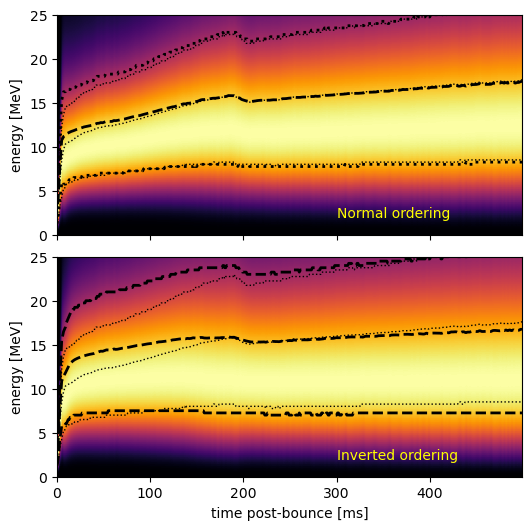

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True, tight_layout=True,
                         gridspec_kw={'hspace': 0.1})

ax = axes[0]
ax.imshow(inorm_nmo.T, origin='lower', extent=extents, aspect='auto', cmap='inferno')

ax.plot(t, E16, color='k', lw=1, ls=':')
ax.plot(t, Eavg, color='k', lw=1, ls=':')
ax.plot(t, E84, color='k', lw=1, ls=':')

ax.plot(t, E16_nmo, color='k', lw=2, ls=':')
ax.plot(t, Eavg_nmo, color='k', lw=2, ls='--')
ax.plot(t, E84_nmo, color='k', lw=2, ls=':')
ax.set(ylabel='energy [MeV]',
      ylim=(0,25))
ax.text(300, 2, 'Normal ordering', color='yellow')

ax = axes[1]
ax.imshow(inorm_imo.T, origin='lower', extent=extents, aspect='auto', cmap='inferno')

ax.plot(t, E16, color='k', lw=1, ls=':')
ax.plot(t, Eavg, color='k', lw=1, ls=':')
ax.plot(t, E84, color='k', lw=1, ls=':')

ax.plot(t, E16_imo, color='k', lw=2, ls='--')
ax.plot(t, Eavg_imo, color='k', lw=2, ls='--')
ax.plot(t, E84_imo, color='k', lw=2, ls='--')
ax.set(xlabel='time post-bounce [ms]',
       ylabel='energy [MeV]',
      ylim=(0,25))
ax.text(300, 2, 'Inverted ordering', color='yellow')

fig.savefig('sn_sukhbold2015_spectrum_nmo.pdf')
fig.savefig('sn_sukhbold2015_spectrum_nmo.png', dpi=150)